In [ ]:
!pip install git+https://github.com/ChaoningZhang/MobileSAM.git
!pip install timm
!pip install keras
!pip install tensorflow

  Cloning https://github.com/ChaoningZhang/MobileSAM.git to /tmp/pip-req-build-8nh20pkr
  Running command git clone --filter=blob:none --quiet https://github.com/ChaoningZhang/MobileSAM.git /tmp/pip-req-build-8nh20pkr
  Resolved https://github.com/ChaoningZhang/MobileSAM.git to commit 12d80d4e32b277de299130d8ce28cc949fb54b6c
  Preparing metadata (setup.py) ... done
  Using cached MarkupSafe-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.0
    Uninstalling MarkupSafe-2.0.0:
ERROR: Could not install packages due to an OSError: [Errno 30] Read-only file system: 'top_level.txt'



In [ ]:
#Dont Move, Random, Physics based gravity line, sampling based (sample wind trajetories) choose best
#RNN,lstm, gru,  liquid, CTRNN both collect data and train to put hand
#llm look at points/images gpt,llava 
import os
import numpy as np
from random import random
import pydot
from matplotlib import pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import pydrake.all as drake
import pydrake.systems.framework as framework
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.all import (
    SpatialForce,
    PackageMap,
    RigidTransform,
    MultibodyPlant,
    StateInterpolatorWithDiscreteDerivative,
    Parser,
    DifferentialInverseKinematicsIntegrator,
    DifferentialInverseKinematicsParameters,
    PortSwitch,
    PassThrough
)
from pydrake.multibody.plant import ExternallyAppliedSpatialForce

from manipulation import running_as_notebook, ConfigureParser, FindResource
from manipulation.station import MakeHardwareStation, load_scenario
from IPython.display import HTML, SVG, display

import torch
from PIL import Image
import numpy as np
from mobile_sam import sam_model_registry, SamPredictor
from keras.models import load_model

model_type = "vit_t"
sam_checkpoint = "/work/mobile_sam.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"
mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()

2023-12-12 00:57:59.696206: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.10/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.10/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.10/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_2

Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
 

In [ ]:
ball_model = "/work/ball.sdf"
pitch_model = "/work/pitch.sdf"
goal_model = "/work/Soccergoal.sdf"
attacker_model = "/work/attack_robots_.sdf" 
defender_model = "/work/defend_robots_.sdf"
spot_model ="/work/spot_with_arm_and_floating_base_actuators.urdf"

In [ ]:
MASS_BALL = 1.1454717
GRAVITY = 9.81
MASS_PLAYER = 1.728014228187
PASSING_MULTIPLIER = 1
SHOOTING_MULTIPLIER = 1
WIND_MULTIPLIER = .2
NET_CENTER = [0,-1, 0 ]
NET_DIMS = [8,2,  2.5]

In [ ]:
def AddSpotRemote(parser):
    parser.package_map().AddRemote(
        package_name="spot_description",
        params=PackageMap.RemoteParams(
            urls=[
                f"https://github.com/wrangel-bdai/spot_ros2/archive/20965ef7bba98598ee10878c7b54e6ef28a300c6.tar.gz"
            ],
            sha256=(
                "20a4f12896b04cc73e186cf876bf2c7e905ee88f8add8ea51bf52dfc888674b4"
            ),
            strip_prefix="spot_ros2-20965ef7bba98598ee10878c7b54e6ef28a300c6/spot_description/",
        ),
    )

In [ ]:
def create_senario_data():
    scenario_data = f"""
    directives:
    - add_model:
        name: pitch
        file: file://{pitch_model}  
    - add_weld:
        parent: world
        child: pitch::pitch_center  
        X_PC: 
            translation: [0, 0, -.01]  
    - add_model:
        name: ball
        file: file://{ball_model}
        default_free_body_pose:
            ball: # Change here!
                translation: [0, 20, .2]
                rotation: !Rpy {{ deg: [42, 33, 18] }}  
    - add_model:
        name: spot
        file: file://{spot_model}
        default_joint_positions:
            arm_sh1: [-3.1]
            arm_el0: [3.1]
    - add_model:
        name: goal
        file: file://{goal_model}
        default_free_body_pose:
            Soccergoal:
                translation: [0., -3., 0.]
                rotation: !Rpy {{ deg: [90, 0, 180] }} 
    """
    
    player_locs = [[0,20], [-5,17], [5,17]]
    for i,p in enumerate(player_locs):
        location_x = p[0]
        location_y = p[1]
        name = "attacker"+ str(i)
        scenario_data += f"""
    - add_model:
        name: {name}
        file: file://{attacker_model}
        default_free_body_pose:
            attack_robots_:
                translation: [{location_x}, {location_y}, 1.5]
                rotation: !Rpy {{ deg: [90, 0, 180] }}"""

    defender_locs = [[0,5], [-3,6], [3,6]]
    for i, d in enumerate(defender_locs):
        location_x = d[0]
        location_y = d[1]
        name = "defender"+ str(i)
        scenario_data += f"""
    - add_model:
        name: {name}
        file: file://{defender_model}
        default_free_body_pose:
            police_robots_:
                translation: [{location_x}, {location_y}, 1.5]
                rotation: !Rpy {{ deg: [90, 0, 0] }}"""
    scenario_data +="""
    model_drivers:
        spot: !InverseDynamicsDriver {}
    cameras:
        hand:
            X_PB:
                base_frame: arm_link_wr1
                rotation: !Rpy
                    deg: [-80.9999763610074, -1.272221872585406e-14, -90.00000000000001]
                translation: [0.13805999999999996, 0.020205000000000008, 0.024519999999999875]
            center_x: 320.0
            center_y: 240.0
            focal: {x: 552.0291012161067, y: 552.0291012161067}
            height: 480
            name: hand
            width: 640"""
    
    return scenario_data

In [ ]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://443541ce-e170-4459-8340-438ed0837988.deepnoteproject.com/7000/


In [ ]:
def AddSpotDifferentialIK(builder, plant, frame=None, time_step= .1):
    params = DifferentialInverseKinematicsParameters(
        plant.num_positions(), plant.num_velocities()
    )
    q0 = plant.GetPositions(plant.CreateDefaultContext())
    params.set_nominal_joint_position(q0)
    params.set_time_step(time_step)
    params.set_end_effector_angular_speed_limit(2)
    params.set_end_effector_translational_velocity_limits(
        [-2, -2, -2], [2, 2, 2]
    )
    if frame is None:
        frame = plant.GetFrameByName("body")
    differential_ik = builder.AddSystem(
        DifferentialInverseKinematicsIntegrator(
            plant,
            frame,
            time_step,
            params,
            log_only_when_result_state_changes=True,
        )
    )
    return differential_ik

In [ ]:
TIME = 0
builder = DiagramBuilder()

scenario = load_scenario(data=create_senario_data())

station = builder.AddSystem(MakeHardwareStation(scenario, meshcat,parser_preload_callback=AddSpotRemote))
plant = station.GetSubsystemByName("plant")

spot_controller = station.GetSubsystemByName(
        "spot.controller"
    )
controller_plant = spot_controller.get_multibody_plant_for_control()

differential_ik = AddSpotDifferentialIK(builder,controller_plant, 
frame=controller_plant.GetFrameByName("arm_link_fngr"),
)
state_interpolator = builder.AddSystem(StateInterpolatorWithDiscreteDerivative(10,.1))
switch = builder.AddSystem(PortSwitch(20))
pass_through= builder.AddSystem(PassThrough(20))

builder.Connect(
    state_interpolator.GetOutputPort("state"),
    switch.DeclareInputPort("diff_ik"),
)

builder.Connect(
    pass_through.get_output_port(),
    switch.DeclareInputPort("position"),)

builder.Connect(
    station.GetOutputPort("spot.state_estimated"),
    differential_ik.GetInputPort("robot_state"),
)

builder.Connect(
    differential_ik.get_output_port(),
    state_interpolator.GetInputPort("position"),)

builder.Connect(
  switch.GetOutputPort("value"),
    station.GetInputPort("spot.desired_state"),)

diagram = builder.Build() 
simulator = Simulator(diagram)
context = simulator.get_context()


plant_context = plant.GetMyMutableContextFromRoot(context)
diff_context = differential_ik.GetMyMutableContextFromRoot(context)
pass_through_context = pass_through.GetMyMutableContextFromRoot(context)
station_context= station.GetMyMutableContextFromRoot(context)
switch_context = switch.GetMyMutableContextFromRoot(context)

differential_ik.GetInputPort("use_robot_state").FixValue(diff_context, True)

#looking_pose
default_pose = [0 for _ in range(20)]
halfpi=1.57
default_pose[0:10]=[0,0,halfpi,0,-halfpi,halfpi,0,0,0,-halfpi] #high
#default_pose[0:10]=[0,0,halfpi,0,0,halfpi,0,-halfpi,0,-halfpi] #low
pass_through.GetInputPort("u").FixValue(pass_through_context, default_pose)
predictor = SamPredictor(mobile_sam)

Both `d` and `Tr` parameters defined for "07___Default". Use the value of `d` for dissolve (line 20 in .mtl.)
Both `d` and `Tr` parameters defined for "07___Default". Use the value of `d` for dissolve (line 20 in .mtl.)



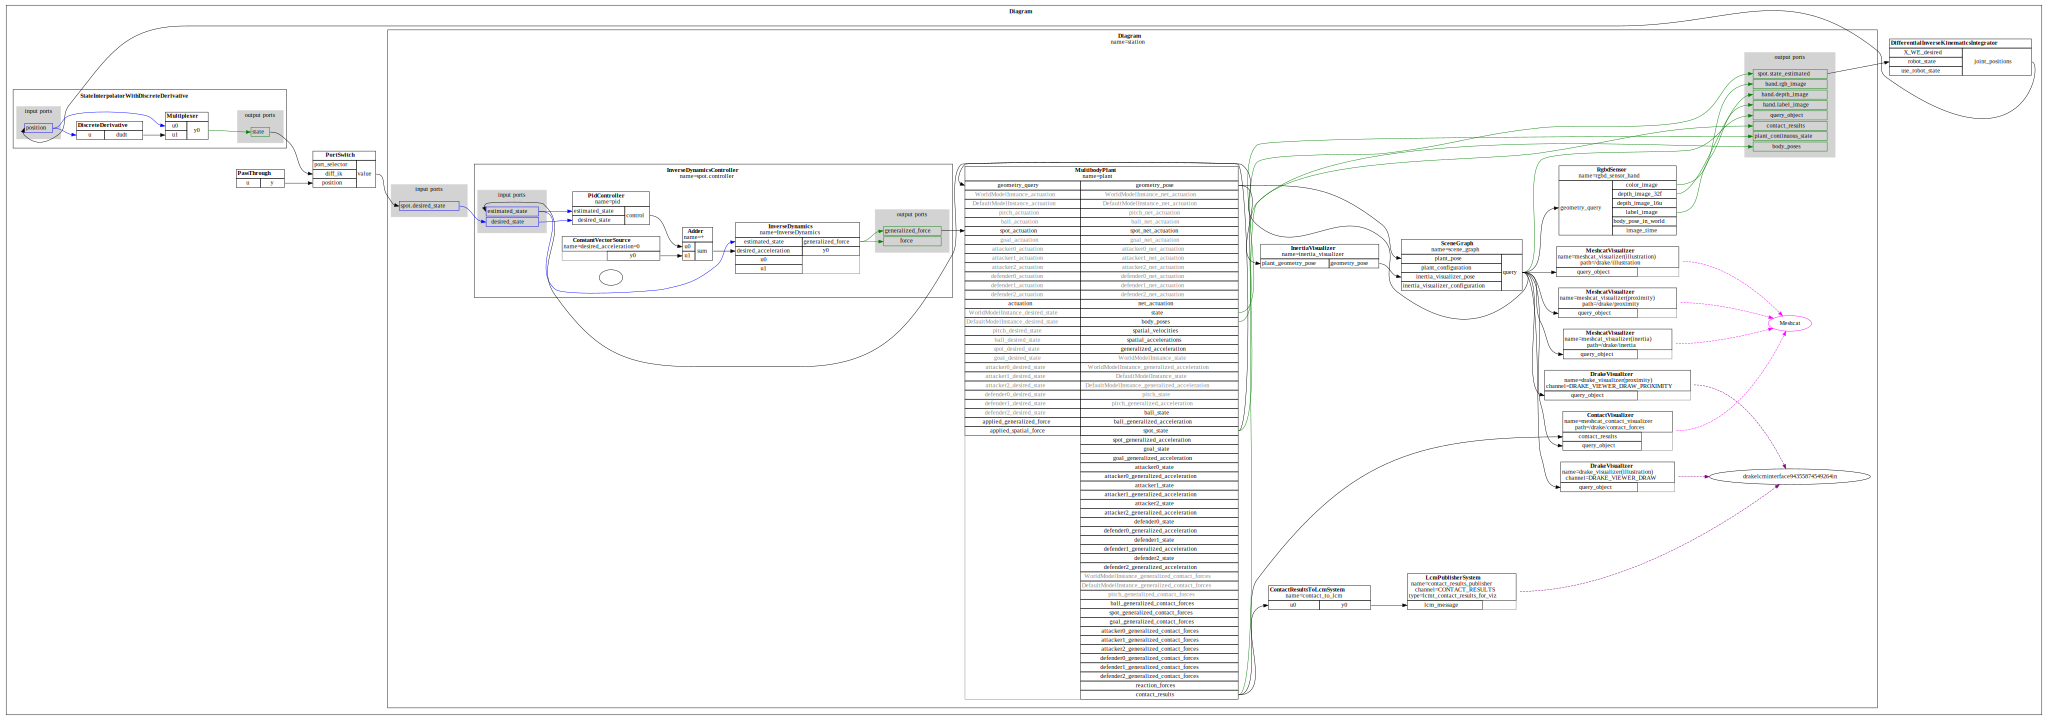

In [ ]:
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

# Soccer Sim

In [ ]:
def check_line_segment_intersection(last_pos, current_pos, x_min, x_max, y_min, y_max, z_min, z_max):
    # Define the planes of the rectangular prism
    planes = [
        {'point': (x_min, y_min, z_min), 'normal': (0, -1, 0)},  # Front face
        {'point': (x_min, y_max, z_min), 'normal': (0, 1, 0)},   # Back face
    ]

    # Iterate over each plane to check for intersection
    for plane in planes:
        if intersect_line_plane(last_pos, current_pos, plane['point'], plane['normal'], x_min, x_max, y_min, y_max, z_min, z_max):
            return True

    return False

def intersect_line_plane(p1, p2, plane_point, plane_normal, x_min, x_max, y_min, y_max, z_min, z_max):
    """
    Check if the line segment between p1 and p2 intersects with the plane defined by plane_point and plane_normal.
    """
    # Line vector
    line_vec = [p2[i] - p1[i] for i in range(3)]

    # Calculate dot products
    dot_nv = sum(plane_normal[i] * line_vec[i] for i in range(3))
    if dot_nv == 0:
        return False  # Line and plane are parallel

    # Calculate the parameter t for the line equation
    dot_np1 = sum(plane_normal[i] * (p1[i] - plane_point[i]) for i in range(3))
    t = -dot_np1 / dot_nv

    # Check if the intersection point is within the line segment
    if 0 <= t <= 1:
        intersection = [p1[i] + t * line_vec[i] for i in range(3)]

        # Check if the intersection point is within the bounds of the prism face
        return (x_min <= intersection[0] <= x_max and
                y_min <= intersection[1] <= y_max and
                z_min <= intersection[2] <= z_max)

    return False


In [ ]:
def check_goal(plant, plant_context,last_ball_pos,  X_MAX = 10, Y_MAX = 30, state= "moving"):
    #returns reset and if goal
    net_x_min = NET_CENTER[0] - NET_DIMS[0]/2
    net_x_max = NET_CENTER[0] + NET_DIMS[0]/2
    net_y_min = NET_CENTER[1] - NET_DIMS[1]
    net_y_max = NET_CENTER[1]
    net_z_min = NET_CENTER[2]
    net_z_max = NET_CENTER[2] + NET_DIMS[2]

    current_ball_pos = plant.GetPositions(plant_context, plant.GetModelInstanceByName("ball"))[4:]

    goal = check_line_segment_intersection(last_ball_pos, current_ball_pos, net_x_min, net_x_max, net_y_min, net_y_max, net_z_min, net_z_max)

    if  state == "waiting" and not goal:
        real_ball_pos =  plant.GetPositions(plant_context, plant.GetModelInstanceByName("ball"))[4:]
        if real_ball_pos[1] < 3:
            acell = plant.GetOutputPort("ball_generalized_acceleration").Eval(plant_context)[3:]
            vel = plant.GetVelocities(plant_context, plant.GetModelInstanceByName("ball")
            ) [:3]
            yacell = acell[1]
            yvel = vel[1]
            detla_pos = (current_ball_pos - real_ball_pos)
            if detla_pos[1]<0 or  real_ball_pos[0]< net_x_min or real_ball_pos[0]> net_x_max  :
         #   if (yvel>=-.00001) and yacell>0:
            #    print("vel", yvel, "acell", yacell)
            #    print("blocked")
                return current_ball_pos, True, False, False

    out_bounds  = current_ball_pos[1] < net_y_min or current_ball_pos[0] < -X_MAX or \
            current_ball_pos[0] > X_MAX or current_ball_pos[1] > Y_MAX

    reset = goal or out_bounds
            
    return current_ball_pos, reset, goal, out_bounds

In [ ]:
def get_force(plant, plant_context, force_vector, name, MULTIPLIER= 1):
    # Create the SpatialForce object
    spatial_force = SpatialForce(tau=np.zeros(3), f=np.array(force_vector)*MULTIPLIER)
    body_index = plant.GetBodyIndices(plant.GetModelInstanceByName(name))[0]
    force_object = ExternallyAppliedSpatialForce()
    force_object.body_index = body_index
    force_object.F_Bq_W = spatial_force
    return force_object

In [ ]:
def reset_force_ball(plant, plant_context):
    acells = plant.GetOutputPort("ball_generalized_acceleration").Eval(plant_context)[3:]
    force_apply = -acells * MASS_BALL
    remove_velocities(plant, plant_context, "ball")
    return get_force(plant, plant_context, force_apply, "ball")

In [ ]:
def apply_forces(plant, plant_context, forces):
    plant.get_applied_spatial_force_input_port().FixValue(plant_context, forces)

In [ ]:
def remove_velocities(plant, plant_context, name):
    #set all velocities to 0
    vel = plant.GetVelocities(plant_context, plant.GetModelInstanceByName(name))
    plant.SetVelocities(plant_context, plant.GetModelInstanceByName(name), np.zeros_like(vel))

In [ ]:
def set_position(plant, plant_context, location, name):
    plant.SetPositions(plant_context, plant.GetModelInstanceByName(name), location)

In [ ]:
def clean_players(plant, plant_context, num_attackers = 3, num_defenders = 3):
    objects = [str(f'defender{i}') for i in range(num_defenders)] + [str(f'attacker{i}') for i in range(num_attackers)]
    forces =[]
    for obj in objects:
        remove_velocities(plant, plant_context,obj )
        forces.append(get_force(plant, plant_context, [0,0,GRAVITY*MASS_PLAYER], obj))
    return forces

In [ ]:
def shoot_ball(plant, plant_context, sim_time_step, target=[0,0,0]):
    ball_pos = plant.GetPositions(
    plant_context, plant.GetModelInstanceByName("ball")
    ) 
    vel = plant.GetVelocities(plant_context, plant.GetModelInstanceByName("ball")
    ) [:3]

    time_to_travel =np.random.rand() +1 
    displacement = np.array(target) - np.array(ball_pos[4:])
    avg_velocity_needed = displacement / time_to_travel
    acceleration_needed = (avg_velocity_needed - vel) / time_to_travel
    acceleration_needed[2] += GRAVITY*sim_time_step
    force = (MASS_BALL * acceleration_needed)/sim_time_step
    
    return get_force(plant, plant_context, force, "ball",MULTIPLIER=SHOOTING_MULTIPLIER), force*SHOOTING_MULTIPLIER

In [ ]:
def apply_wind(plant, plant_context, sim_time_step, target= [0,0,0]):
    ball_pos = plant.GetPositions(
    plant_context, plant.GetModelInstanceByName("ball")
    ) 
    vel = plant.GetVelocities(plant_context, plant.GetModelInstanceByName("ball")
    ) [:3]

    time_to_travel =np.random.rand() +1.5 
    displacement = np.array(target) - np.array(ball_pos[4:])
    avg_velocity_needed = displacement / time_to_travel
    acceleration_needed = (avg_velocity_needed - vel) / time_to_travel
    acceleration_needed[2] += GRAVITY*sim_time_step
    force = (MASS_BALL * acceleration_needed)/sim_time_step
    
    
    return get_force(plant, plant_context, force, "ball",MULTIPLIER=WIND_MULTIPLIER), force*WIND_MULTIPLIER

In [ ]:
def pass_ball(plant_context,plant,player_index,sim_time_step, num_attacker=3):
   # print("current index", player_index)
    possible_indices = [i for i in range(num_attacker) if i != player_index]
    pass_to_person = np.random.choice(possible_indices)
   # print("Passing to index",pass_to_person )

    next_pos = plant.GetPositions(
    plant_context, plant.GetModelInstanceByName("attacker"+str(pass_to_person))
    )[4:]
    
    pos = plant.GetPositions(
    plant_context, plant.GetModelInstanceByName("ball")
    ) [4:]
    vel = plant.GetVelocities(plant_context, plant.GetModelInstanceByName("ball")
    ) [:3]

    time_to_travel =.5+ np.random.rand() 

    displacement = np.array(next_pos) - np.array(pos)
    avg_velocity_needed = displacement / time_to_travel
    acceleration_needed = (avg_velocity_needed -vel) / time_to_travel
    force = (MASS_BALL * acceleration_needed)/sim_time_step

    
    return get_force(plant, plant_context, force, "ball", MULTIPLIER= PASSING_MULTIPLIER), pass_to_person,  force

In [ ]:
def move_defenders(plant, plant_context, sim_time_step, num_defenders=3, defender_movement_distance=0.5):
    """
    Move defenders in the simulation, applying random jitter to their positions.

    Args:
        plant (Plant): The plant model.
        plant_context (Context): The context of the plant.
        sim_time_step (float): The simulation time step.
        num_defenders (int): Number of defenders.
        defender_movement_distance (float): Movement distance for defenders.

    Returns:
        None: This function modifies the defenders' positions in-place.
    """
    for i in range(num_defenders):
        defender_name = "defender" + str(i)
        defender_pos = plant.GetPositions(plant_context, plant.GetModelInstanceByName(defender_name))

        random_jitter = np.random.normal(0, 1, 3) * defender_movement_distance
        random_jitter[2] = 0  # Assuming the z-axis is vertical and should not change

        defender_pos_new = defender_pos[4:] + random_jitter * sim_time_step
        defender_pos[4:] = defender_pos_new

        set_position(plant, plant_context, defender_pos, defender_name)


In [ ]:
def move_attackers(plant, plant_context, current_attacker_index, sim_time_step, num_attackers=3,
                   attacker_movement_distance=3, collect=False):
    """
    Move attackers towards the goal and handle ball movement.
    
    Args:
        plant (Plant): The plant model.
        plant_context (Context): The context of the plant.
        current_attacker_index (int): Index of the current attacker.
        sim_time_step (float): The simulation time step.
        num_attackers (int): Number of attackers.
        attacker_movement_distance (float): Movement distance for attackers.
        collect (bool): Flag to determine movement strategy.

    Returns:
        np.array: New position of the ball.
    """
    attacker_with_ball = "attacker" + str(current_attacker_index)
    ball_pos = plant.GetPositions(plant_context, plant.GetModelInstanceByName("ball"))

    goal_target = np.array([0, 0, 0])
    direction_to_goal = goal_target - ball_pos[4:]
    direction_norm = np.linalg.norm(direction_to_goal)
    direction_to_goal_normalized = direction_to_goal / direction_norm if direction_norm != 0 else np.zeros_like(direction_to_goal)
    
    COLLECT_MOVEMENT_DISTANCE = 5
    if collect:  # If collect is true, reduce movement distance
        attacker_movement_distance =.5

    for i in range(num_attackers):
        attacker_name = "attacker" + str(i)
        attacker_pos = plant.GetPositions(plant_context, plant.GetModelInstanceByName(attacker_name))
        random_jitter = np.random.normal(0, 1, 3) * attacker_movement_distance / 3
        random_jitter[2] = 0  # Assuming z-axis is vertical and should not change

        attacker_pos_new = attacker_pos[4:] + (direction_to_goal_normalized * attacker_movement_distance + random_jitter) * sim_time_step
        attacker_pos[4:] = attacker_pos_new
        set_position(plant, plant_context, attacker_pos, attacker_name)

        if attacker_name == attacker_with_ball:
            if collect:
                direction_to_ball = ball_pos[4:] - attacker_pos[4:]
                direction_to_ball[2] = 0
                direction_norm_ball = np.linalg.norm(direction_to_ball)
                direction_to_ball_normalized = direction_to_ball / direction_norm_ball if direction_norm_ball != 0 else np.zeros_like(direction_to_ball)

                attacker_pos_new = attacker_pos[4:] + (direction_to_ball_normalized * COLLECT_MOVEMENT_DISTANCE ) * sim_time_step
                attacker_pos[4:] = attacker_pos_new
                set_position(plant, plant_context, attacker_pos, attacker_name)
                collected =  ( np.linalg.norm(attacker_pos_new - ball_pos[4:]) < 4)
            else:
                radius = 0.5
                ball_jitter = np.random.normal(0, 1, 3)
                ball_jitter[2] = 0
                ball_jitter_norm = ball_jitter / np.linalg.norm(ball_jitter) * radius
                ball_pos_new = attacker_pos_new + ball_jitter_norm
                ball_pos_new[2] = .3
                ball_pos[4:] = ball_pos_new
                set_position(plant, plant_context, ball_pos, "ball")

    if collect:
        return ball_pos[4:] , collected
    return ball_pos_new, None

In [ ]:
def next_state(ball_loc, info="other"):
    shooting_zone = [8, 15]
    
    if info ==  "collected":
        return "moving"

    if ball_loc[1] >=shooting_zone[0] and ball_loc[1] <=shooting_zone[1]:
        if (np.random.rand() >=.75):
            return "shooting"
        elif (np.random.rand() >=.60):
            return "passing" 
        else:
            return "moving"
    elif ball_loc[1] <shooting_zone[0]:
        return "shooting"
    else:
        if (np.random.rand() >=.95):
            return "passing" 
        else:
            return "moving"

In [ ]:
def move_ball(plant, plant_context, current_attacker_index, sim_time_step):
    move_defenders(plant, plant_context, sim_time_step)
    ball_loc, _ = move_attackers(plant, plant_context,current_attacker_index, sim_time_step)
    return next_state(ball_loc)

In [ ]:
def collect_ball(plant, plant_context, current_attacker_index, sim_time_step):
    move_defenders(plant, plant_context, sim_time_step)
    ball_loc, collected= move_attackers(plant, plant_context,current_attacker_index, sim_time_step,collect=True)
    if not collected:
        return "collecting" 
        
    return next_state(ball_loc, "collected")

# Spot Controllers

In [ ]:
def move_hand(plant, plant_context, target= [0,5,1]):
    #moves spot end effector to target
    transform = RigidTransform(target)
    differential_ik.GetInputPort("X_WE_desired").FixValue(diff_context, transform)

In [ ]:
def random_control(state):
    if state == "shooting":
        random_target = np.random.uniform(0, 1, 3)
        random_target[0]*=3
        random_target[0]-=random_target[0]/2
        random_target[1]*=3
        random_target[2]*=2
        return random_target
    return None

In [ ]:
def samplingbasedcontroller(history, samples = 5, sim_time_step = .1 ):

    if (len(history) >= 3):
        potential_points = []
        ball_pos = np.copy(history[-2][2])
        for i in range(samples):
            first_point = np.copy(history[-3][2])
            second_point =np.copy(history[-2][2])
            time_between_camera= np.copy(history[-3][1]) - np.copy(history[-2][1])

            v0= -(second_point-first_point)/time_between_camera
       #     v0[0]*=-1

            target = [np.random.rand()*NET_DIMS[0]- NET_DIMS[0]/2,-2, (NET_DIMS[2]-1)*np.random.rand()]
            time_to_travel =2
            displacement = np.array(target) - ball_pos
            avg_velocity_needed = displacement / time_to_travel
            acceleration_needed = (avg_velocity_needed - v0) / time_to_travel
            acceleration_needed[2] += GRAVITY*sim_time_step
            force = WIND_MULTIPLIER*(MASS_BALL * acceleration_needed)/sim_time_step
            acceleration_needed /= MASS_BALL

            gravity = np.array([0,0,-9.81]) + acceleration_needed

            # integreate to time history[-1][1]
            t = .05
            time  = np.copy(history[-1][1]) - np.copy(history[-2][1])
            totalt = 0
            while totalt < time:
                second_point +=  v0*t + gravity*t**2
                totalt +=t
            
            potential_points +=[second_point, acceleration_needed]
        third_point = np.copy([history[-1][2]])
        bestdist = float('inf') 
    #    finalpoint = np.array([0,0,0])
        for pi in potential_points:
            dist = np.linalg.norm(third_point -pi[0] )
            if dist < bestdist:
                bestdist = dist
    #            finalpoint = pi[0]
                final_accel = pi[1]

        first_point = np.copy(history[-2][2])
        second_point =np.copy(history[-1][2])
        gravity = np.array([0,0,-9.81]) + final_accel
        time_between_camera= np.copy(history[-2][1]) - np.copy(history[-1][1])
        v0= -(second_point-first_point)/time_between_camera
  #      v0[0]*=-1
        t = .05
        count = 0
        while True:
            second_point +=  v0*t + gravity*t**2
            if (second_point[1] > 0 and second_point[1] < 3) or count >3 :
                break
            count +=1
            
        
        return second_point

    return None

In [ ]:
def physicsbasedcontroller(history):
    if (len(history) >= 2):
        #history =[[0,0,0],[0,0,0],t, ]
        #xf = x0 + v_0*t+1/2*g*t^2 
        first_point = np.copy(history[-2][2])
        second_point =np.copy(history[-1][2])
        gravity = np.array([0,0,-9.81])
        time_between_camera= np.copy(history[-2][1]) - np.copy(history[-1][1])
        v0= -(second_point-first_point)/time_between_camera
       # v0[0]*=-1
        t = .05
        count = 0
        while True:
            second_point +=  v0*t + gravity*t**2
            if (second_point[1] > 0 and second_point[1] < 3) or count >3 :
                break
            count +=1
            
        
        return second_point
    return None

In [ ]:
rnn_model =  load_model('/work/RNN.h5', compile=False)
lstm_model = load_model('/work/LSTM.h5', compile=False)
gru_model = load_model('/work/GRU.h5', compile=False)

def nn_controller(past_ball_positions, window= 3, control = "rnn"):
    if (len(past_ball_positions) >= window):
        win = window*-1
        for w in past_ball_positions[win:]:
            if w[0] != "waiting" and  w[0] != "shooting":
                return None
        data = [w[2] for w in past_ball_positions[win:] ]
        inputs = np.array(data).reshape(-1, window,3)
        if control == "rnn":
            target = rnn_model.predict(inputs, verbose=0)[0]
        elif control == "lstm":
            target = lstm_model.predict(inputs, verbose=0)[0]
        elif control == "gru":
            target = gru_model.predict(inputs, verbose=0)[0]


        return target



In [ ]:
import tensorflow as tf
class ODEFunc(tf.keras.Model):

    def __init__(self, **kwargs):
        super(ODEFunc, self).__init__(**kwargs)
        self.model = model

    def call(self, t, y):
    #    t = tf.cast(t, tf.float64)
        y = tf.cast(y, tf.float32)
        return self.model([y, t])

model = load_model('/work/rnn_ode.h5', compile=False)
func = ODEFunc()
func.model = model

def ode_int(func, y_0, t, state):
  dy_dt = func(t, state)
  sol = y_0 + dy_dt*t
  return sol

def ode_solve(past_ball_positions, window= 3, control = "rnn"):
    if (len(past_ball_positions) >= window):
        win = window*-1
        for w in past_ball_positions[win:]:
            if w[0] != "waiting" and  w[0] != "shooting":
                return None

        window_data = past_ball_positions[win:]
        early_time = past_ball_positions[win][1]
        data = [ [w[2][0], w[2][1], w[2][2], w[1]- early_time] for w in window_data]
        state = np.array(data).reshape(-1, window,4)

        t = np.array([past_ball_positions[-1][1]- early_time +.75])
        y_0 = np.copy(past_ball_positions[-1][2])
        pos_next = ode_int(func,y_0, t, state )[0]

        if (pos_next[1] > 0 and pos_next[1] < 3):
            return pos_next
    return None
    

In [ ]:
def controler(plant, plant_context, state,time, past_ball_positions= [], control = "random", use_camera = True):
    ball_pos = get_from_camera(plant, plant_context, display= False)
    real_ball_pos =  plant.GetPositions(plant_context, plant.GetModelInstanceByName("ball"))[4:]
    if ball_pos is not None:
        past_ball_positions.append([state,time,  ball_pos])

    #in controler use ball postions and states to determie to go to target 
    target = None
    if control == "stay":
        return past_ball_positions, False
    elif control == "random":
        target = random_control(state)
    elif control == "phy":
        target = physicsbasedcontroller(past_ball_positions)
    elif control == "sample":
        target = samplingbasedcontroller(past_ball_positions)
    elif control == "rnn":
        target = nn_controller(past_ball_positions, control= "rnn")
    elif control == "lstm":
        target = nn_controller(past_ball_positions, control= "lstm")
    elif control == "gru":
        target = nn_controller(past_ball_positions, control= "gru")
    elif control == "lstm_ode":
        target = ode_solve(past_ball_positions)

    if target is not None:
        hand_pos = plant.GetFrameByName("arm_link_fngr").body().EvalPoseInWorld(plant_context).translation()
        distance = np.linalg.norm(hand_pos - target)
        net_x_min =  NET_CENTER[0] - NET_DIMS[0]/2
        net_x_max = NET_CENTER[0] + NET_DIMS[0]/2
      #  print("target",target )
      #  print("distance", distance) move if target is in goal zone or real ball is in kill zone
        if target[0] > net_x_min  and target[0] < net_x_max  and  ((target[1] > 0 and target[1] < 4)) :
       #     print("target", target)
            move_hand(plant, plant_context, target= target)
            return past_ball_positions, True
    
    #continue collecting data
    return past_ball_positions, False

In [ ]:
@torch.no_grad()
def get_from_camera(plant, plant_context, display = False):
    color_image = station.GetOutputPort("hand.rgb_image").Eval(station_context)
   # depth_image = station.GetOutputPort("hand.depth_image").Eval(station_context)
    

    img = color_image.data[:, :, :3]

    white_threshold = np.array([240, 240, 240])
    white_pixels = np.where(np.all(img >= white_threshold, axis=-1))

    ball_pos = None

    if len(white_pixels[0]) >= 2:
        
        # Select bounding box white pixels
        x_min, y_min = np.min(white_pixels[1]), np.min(white_pixels[0])
        x_max, y_max = np.max(white_pixels[1]), np.max(white_pixels[0])

        # Prepare the input for the model
        predictor.set_image(img)
        input_box = np.array([x_min,y_min,x_max, y_max])

        masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
        )

        object_coords = np.argwhere(masks[0])
        center_of_object = np.mean(object_coords, axis=0)
        if not np.isnan(center_of_object).any():
            row_center, col_center = center_of_object
            row_center_int, col_center_int = int(round(row_center)), int(round(col_center))
            if display:
                plt.figure(figsize=(6, 12))
                plt.subplot(6, 2, 1)
                plt.imshow(img)
                plt.scatter(col_center_int, row_center_int, c='red', s=10)
                plt.show()

            #assume depth camera would have gotten good result
            real_ball_pos =  plant.GetPositions(plant_context, plant.GetModelInstanceByName("ball"))[4:]
            transform = plant.GetFrameByName("arm_link_fngr").body().EvalPoseInWorld(plant_context)
            depth = np.abs(real_ball_pos- transform.translation())[1]

            c_x = 320.0  # optical center x-coordinate
            c_y = 240.0   # optical center y-coordinate
            f_x = 552.0291012161067 # focal length in x
            f_y = 552.0291012161067  # focal length in y

            FLOOR_DELTA = 4.5

            X = (col_center_int  - c_x) * depth / f_x
            Y = real_ball_pos[2] + .26*np.random.randn()
         #   Y = (row_center_int  - c_y) * depth / f_y  - FLOOR_DELTA
          #  if Y < -1:
          #      Y = .5

            Z =  depth 
         #   print("pretransfrom", [X,Z,Y])
            ball_pos = np.array((RigidTransform([X,Z,Y])@transform).translation())
        #    print("real", real_ball_pos)
       #     print("predicted", ball_pos)
       #     print(ball_pos)
            return ball_pos

    
    return ball_pos

# Episodes

In [ ]:
def reset_episode(plant, plant_context):
    attacker_locs = [[0,25], [-5,22], [5,22]]
    defender_locs = [[0,5], [-3,6], [3,6]]

    for i,p in enumerate(attacker_locs):
        location_x = p[0]+ (np.random.rand()*2 -1)
        location_y = p[1]+ (np.random.rand()*2 -1)
        name = "attacker"+ str(i)
        attacker_pos = plant.GetPositions(plant_context, plant.GetModelInstanceByName(name))
        attacker_pos[4:] = np.array([location_x, location_y, 1 ])
        set_position(plant, plant_context, attacker_pos, name)
        if i == 0:
            ball_pos = plant.GetPositions(plant_context, plant.GetModelInstanceByName("ball"))
            ball_pos[4:] = np.array([location_x, location_y+1, 1.5] )
            set_position(plant, plant_context, ball_pos, "ball")
    
    for i,p in enumerate(defender_locs):
        location_x = p[0]+ (np.random.rand()*1 -1)
        location_y = p[1]+ (np.random.rand()*1 -1)
        name = "defender"+ str(i)
        defender_pos = plant.GetPositions(plant_context, plant.GetModelInstanceByName(name))
        defender_pos[4:] = np.array([location_x, location_y, 1] )
        set_position(plant, plant_context, defender_pos, name)

    differential_ik.GetInputPort("X_WE_desired").FixValue(diff_context, RigidTransform([0,0,0]))
    switch.GetInputPort("port_selector").FixValue(switch_context,  switch.GetInputPort("position").get_index())

In [ ]:
def run_episode(plant, plant_context, TIME, sim_time_step = .1, max_sim = 20, controller= "stay" ):
    reset_episode(plant, plant_context)
    meshcat.StartRecording()
    time_ = 0
    current_attacker_index = 0
    #states shooting, moving, passing, collecting_ball, waiting
    state = "moving"
    shot_time = 0
    MAX_TIME_SINCE_SHOT = 5 
    looking = True 
    passing_force= None
    shooting_force = None
    forces = []
    target_shoot = [np.random.rand()*NET_DIMS[0]- NET_DIMS[0]/2,-2, (NET_DIMS[2]-1)*np.random.rand()]
    target_wind =  [np.random.rand()*NET_DIMS[0]- NET_DIMS[0]/2,-2, (NET_DIMS[2]-1)*np.random.rand()]
   # print("target shot", target_shoot)
   # print("target wind", target_wind)
    last_ball_pos = plant.GetPositions(plant_context, plant.GetModelInstanceByName("ball"))[4:]

    shortest_distance_hand = float("inf")

   # last_time_move = 0 

    ball_postions_context = []

   # best_blocking_positions = []

    while True:
        apply_forces(plant, plant_context, forces)
        time_ += sim_time_step
        simulator.AdvanceTo(time_ +TIME)
        forces = clean_players(plant,plant_context)
    
        if looking:
            ball_postions_context, done_looking = controler(plant, plant_context,state, time_,  past_ball_positions=ball_postions_context, control=controller)
            if done_looking:
                switch.GetInputPort("port_selector").FixValue(switch_context,  switch.GetInputPort("diff_ik").get_index())
                looking = False

        #move bot every second
        #(time_ - last_time_move) >=1 and
        if  len(ball_postions_context) >0 :
         #   last_time_move = time_
            x = ball_postions_context[-1][2][0]
            net_x_min =  NET_CENTER[0] - NET_DIMS[0]/2
            net_x_max = NET_CENTER[0] + NET_DIMS[0]/2
            if x> net_x_min  and x < net_x_max :
                hand_pos_x = plant.GetFrameByName("arm_link_fngr").body().EvalPoseInWorld(plant_context).translation()[0]
                pose = default_pose[:]
                delta = x-hand_pos_x
                pose[0] = delta
                pass_through.GetInputPort("u").FixValue(pass_through_context, pose)
            else:
                pass_through.GetInputPort("u").FixValue(pass_through_context, default_pose)

        if state == "moving":
            state = move_ball(plant, plant_context, current_attacker_index, sim_time_step)
            if passing_force is not None:
                #apply counter force to ball
              #  forces.append(get_force(plant, plant_context, -1*passing_force, "ball",MULTIPLIER= PASSING_MULTIPLIER))
                forces.append(reset_force_ball(plant, plant_context))
                passing_force = None

        elif state == "passing":
            force, current_attacker_index,passing_force  = pass_ball(plant_context,plant,current_attacker_index,sim_time_step)
            forces.append(force)
            state = "collecting"

        elif state == "shooting":
            force, shooting_force = shoot_ball(plant, plant_context, sim_time_step, target=target_shoot)
            forces.append(force)
            state = "waiting"

        elif state == "collecting":
            state = collect_ball(plant, plant_context, current_attacker_index, sim_time_step)

        elif state == "waiting":
            force, wind_force = apply_wind(plant, plant_context, sim_time_step,target =  target_wind)
            shooting_force += wind_force
            forces.append(force)
            move_defenders(plant, plant_context, sim_time_step)
            shot_time+= sim_time_step
        


        
        #print(time_, state)
        last_ball_pos, episode_over, goal, out_bounds = check_goal(plant, plant_context, last_ball_pos, state=state)
        
      #  if last_ball_pos[1]>=1 and state == "waiting":
      #      best_blocking_positions.append([time_, last_ball_pos])

        hand_pos = plant.GetFrameByName("arm_link_fngr").body().EvalPoseInWorld(plant_context).translation()
        distance = np.linalg.norm(last_ball_pos - hand_pos)


        if distance< shortest_distance_hand:
            shortest_distance_hand = distance

        if time_ >= max_sim or episode_over or shot_time > MAX_TIME_SINCE_SHOT:
            out_bounds = True
            break

    #clean up
    forces =[]
    if shooting_force is not None:
    #apply counter force to ball
  #      forces.append(get_force(plant, plant_context, -1*shooting_force, "ball",MULTIPLIER= 1))
        forces.append(reset_force_ball(plant, plant_context))
        shooting_force = None
    apply_forces(plant, plant_context, forces)
    remove_velocities(plant, plant_context,"ball" )
    pass_through.GetInputPort("u").FixValue(pass_through_context, default_pose)
    switch.GetInputPort("port_selector").FixValue(switch_context,  switch.GetInputPort("position").get_index())
    time_ += sim_time_step
    simulator.AdvanceTo(time_ +TIME)
    TIME += time_

  #  print("Goal", goal)
   # print(shortest_distance_hand)
    meshcat.PublishRecording()
    return TIME, goal, ball_postions_context, shortest_distance_hand

In [ ]:
"""#collect data
import pickle
import os

filename = "/work/history_best_protect_new.pkl"
for i in range(1000):
    TIME, goal, history, best_blocking_pos = run_episode(plant, plant_context, TIME, controller= "stay")
    if goal:
        data = [history, best_blocking_pos]
        if os.path.exists(filename):
            with open(filename, 'rb') as file:
                existing_data = pickle.load(file)
            existing_data.append(data)
            print(len(existing_data))
            with open(filename, 'wb') as file:
                pickle.dump(existing_data, file)
        else:
            with open(filename, 'wb') as file:
                pickle.dump([data], file) """


'#collect data\nimport pickle\nimport os\n\nfilename = "/work/history_best_protect_new.pkl"\nfor i in range(1000):\n    TIME, goal, history, best_blocking_pos = run_episode(plant, plant_context, TIME, controller= "stay")\n    if goal:\n        data = [history, best_blocking_pos]\n        if os.path.exists(filename):\n            with open(filename, \'rb\') as file:\n                existing_data = pickle.load(file)\n            existing_data.append(data)\n            print(len(existing_data))\n            with open(filename, \'wb\') as file:\n                pickle.dump(existing_data, file)\n        else:\n            with open(filename, \'wb\') as file:\n                pickle.dump([data], file) '

In [ ]:
TIME, goal, _, shortest_distance_hand = run_episode(plant, plant_context, TIME, controller= "sample")

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [ ]:
#times = 50
#for name in ["random",  "lstm", "rnn"]:
 #   avg_hand_distance = 0
 #   blocked_count = 0 
 #   for _ in range(times):
 #       TIME, goal, _, shortest_distance_hand = run_episode(plant, plant_context, TIME, controller= "sample")
 #       if not goal:
 #           blocked_count+=1
 #       avg_hand_distance += shortest_distance_hand/times
 #   print("Name:", name, "Hand_distance",avg_hand_distance, "block_count", blocked_count  )

In [ ]:
Name: sample Hand_distance 1.2466688661141276 block_count 36/150
Name: lstm_ode Hand_distance 1.419386903070725 block_count 11/150
Name: phy Hand_distance 1.1988022685982622 block_count 36/150
Name: stay Hand_distance 1.2910692921548383 block_count 15/150

SyntaxError: invalid syntax (2069214953.py, line 1)

Results

Name: stay Hand_distance 1.27502807603325 block_count 9
Name: random Hand_distance 1.9176485305059479 block_count 5
Name: phy Hand_distance 1.7357295696812856 block_count 12
Name: sample Hand_distance 1.417508157217284 block_count 18
Name: lstm Hand_distance 1.3906696503457046 block_count 2
Name: gru Hand_distance 1.365239943907065 block_count 6
Name: rnn Hand_distance 1.5437941208369137 block_count 4

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=443541ce-e170-4459-8340-438ed0837988' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>